In [2]:
import skimage
from scipy.fftpack import fft, ifft, fftshift
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny
import imutils

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from scipy import stats


In [3]:
path="sample2.png"
img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)

--------------------------------HProjection analysis--------------------------------
------------------------------------------------------------------------------------------------

![Projeção horizontal de texto](example.png)

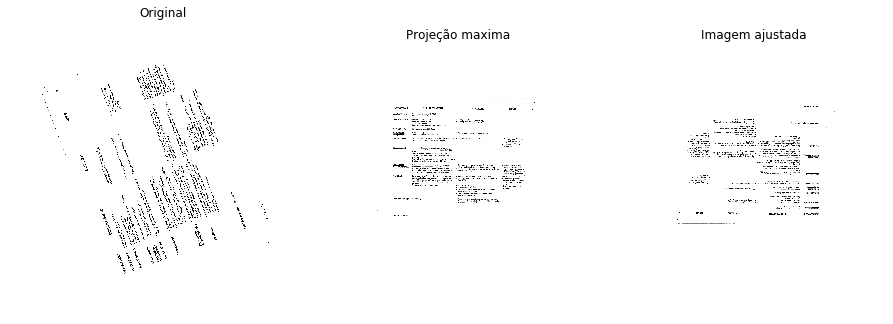

In [4]:
def calcula_proj(img):
    temp=np.bitwise_not(img)
    project=np.sum(temp,1)
    return project

def pico_projection(projection):
    return np.max(projection)

def rotate(img, angle):
    temp=np.bitwise_not(img)
    rotate=imutils.rotate_bound(temp, angle)
    return np.bitwise_not(rotate)

def horizontal_projection(src):
    angulo_encontrado=0
    vp=0
    for angulo in range(180):
        aux=rotate(src,angulo)
        projecao=calcula_proj(aux)
        valor_pico=pico_projection(projecao)
        if(valor_pico>vp):
            angulo_encontrado=angulo
            vp=valor_pico
    if(angulo_encontrado<=90):
        
        return (angulo_encontrado,angulo_encontrado-90)
    else:
        return (angulo_encontrado,-1*(180-angulo_encontrado))

hp_angulo, angulo_resp=horizontal_projection(img)
img_resposta=rotate(img, angulo_resp)
proj_max=rotate(img, hp_angulo)

fig, ax=plt.subplots(1,3, figsize=(15, 6))
axes=ax.ravel()
axes[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Original')
ax[0].set_axis_off()

axes[1].imshow(proj_max, cmap=cm.gray)
ax[1].set_title('Projeção maxima')
ax[1].set_axis_off()

axes[2].imshow(img_resposta, cmap=cm.gray)
ax[2].set_title('Imagem ajustada')
ax[2].set_axis_off()
cv2.imwrite(path[:-4]+"_hproj.png", img_resposta)


plt.show()

In [58]:
print(f"angulo de projeção={hp_angulo},\nangulo ajustado da imagem= {angulo_resp}")

angulo de projeção=111,
angulo ajustado da imagem= -69


--------------------------------Hough Analisys--------------------------------
------------------------------------------------------------------------------------------------

![Projeção horizontal de texto](example2.png)

In [5]:
img = canny(img, 2, 1, 25)

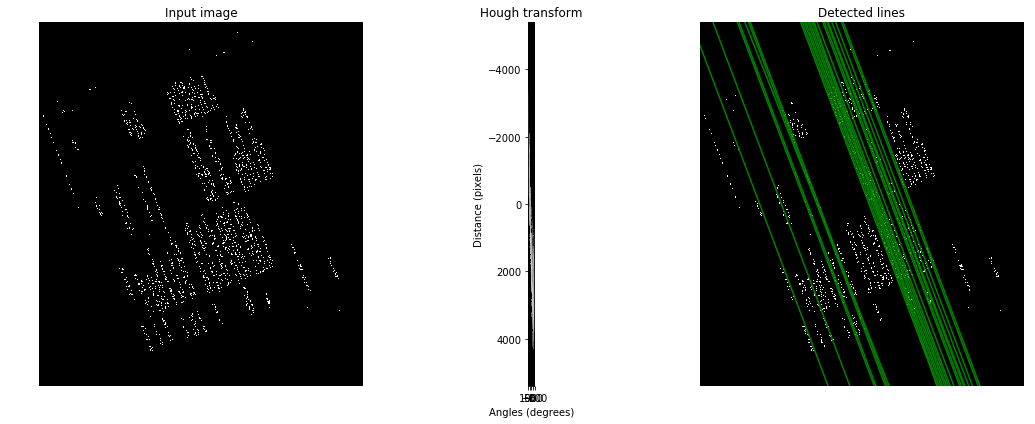

In [6]:
h, theta, d = hough_line(img)
factor=1
minima_amostragem=5
picos=[[0],[0],[0]]
while(len(picos[0])<minima_amostragem):
    factor/=2
    picos=hough_line_peaks(h,theta,d, threshold=np.max(h)*factor)# Classic straight-line Hough transform

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(img, cmap=cm.gray)
angulos=[]

#print(hough_line_peaks(h, theta, d, threshold=np.max(h)*0.1))
for _, angle, dist in zip(picos[0],picos[1],picos[2]):
    angulos.append(np.rad2deg(angle))
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)

    ax[2].plot((0, img.shape[1]), (y0, y1), '-g')
ax[2].set_xlim((0, img.shape[1]))
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [7]:
def moda(array):
    m = stats.mode(array)
    return m[0][0]

angulos=np.round(angulos)
moda_ang=moda(angulos)

if(moda_ang<0):
    print(-1*(90-abs(moda_ang)))
    hough_angle=-1*(90-abs(moda_ang))
else:
    print(90-moda_ang)
    hough_angle=90-moda_ang



-69.0


In [8]:
img=cv2.imread(path, cv2.IMREAD_GRAYSCALE)

aux=rotate(img,hough_angle)
cv2.imwrite(path[:-4]+"_hough.png", aux)

True

--------------------------------Fourier Analisys--------------------------------
------------------------------------------------------------------------------------------------

In [63]:
fourier = np.fft.fft2(img)
fourier_shifted = np.fft.fftshift(fourier)
magnitude_spectrum = 20*np.log(np.abs(fourier_shifted))
magnitude_spectrum=(magnitude_spectrum-np.min(magnitude_spectrum))*(255/(np.max(magnitude_spectrum)-np.min(magnitude_spectrum)))
magnitude_spectrum=np.uint8(magnitude_spectrum)
    
print(np.max(magnitude_spectrum))


255


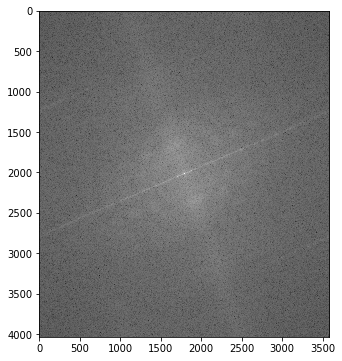

In [64]:
fig, axes=plt.subplots(1,1, figsize=(15,6))
axes.imshow(magnitude_spectrum,cmap=cm.gray)

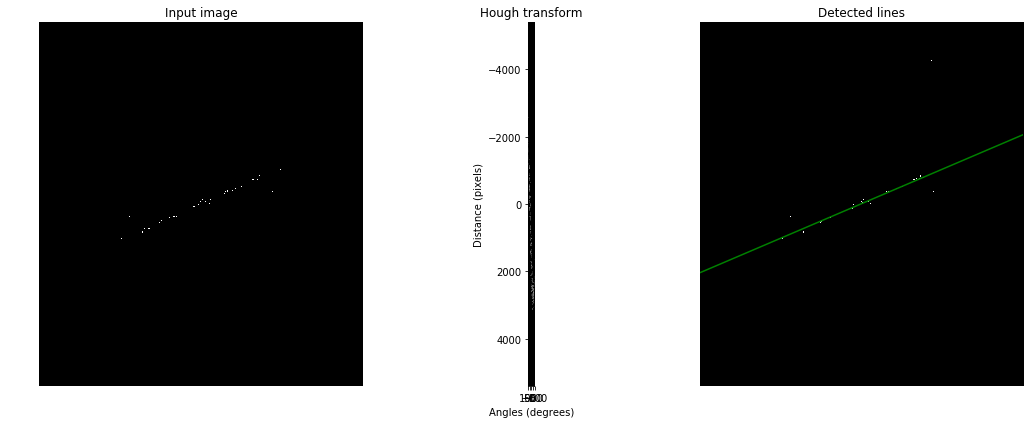

In [65]:
fig, axes = plt.subplots(1,3, figsize=(15, 6))

#calcula o mapa de bordas do aspectro de frequencia
border_map = canny(magnitude_spectrum, 2, 1, 25)
h, theta, d = hough_line(border_map)

axes[0].imshow(border_map, cmap=cm.gray)
axes[0].set_title('Input image')
axes[0].set_axis_off()

axes[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
axes[1].set_title('Hough transform')
axes[1].set_xlabel('Angles (degrees)')
axes[1].set_ylabel('Distance (pixels)')
axes[1].axis('image')

axes[2].imshow(border_map, cmap=cm.gray)
#print(hough_line_peaks(h, theta, d))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, num_peaks=1)):
    #print(angle, dist)
    angulo_final=np.rad2deg(angle)
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    #print(y0)
    y1 = (dist - magnitude_spectrum.shape[1] * np.cos(angle)) / np.sin(angle)
    #print(y1)
    #print("------------------------------------------------------")

    axes[2].plot((0, magnitude_spectrum.shape[1]), (y0, y1), '-g')
axes[2].set_xlim((0, magnitude_spectrum.shape[1]))
axes[2].set_ylim((magnitude_spectrum.shape[0], 0))
axes[2].set_axis_off()
axes[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

In [66]:
print(angulo_final)
if angulo_final >0:
        #print(angulo_final-90)
        angulo_ajustado=angulo_final-90
else:
        #print(angulo_final+90)
        angulo_ajustado=angulo_final+90
        
if(angulo_ajustado<0):
        print(np.round(-1*(90-abs(angulo_ajustado))))
        fourier_angle=np.round(-1*(90-abs(angulo_ajustado)))
else:
        print(np.round(90-angulo_ajustado))
        fourier_angle=np.round(90-angulo_ajustado)

66.87150837988824
-67.0


In [53]:
aux=rotate(img, fourier_angle)
cv2.imwrite(path[:-4]+"_Fourier.png", aux)

True